# Project File
Given the magnitude of the RestNet CNN, it is unfeasible to run it on a local CPU. Hence, in order to run it on Google Collab, all the contents will be fused onto this file to run it there. Initially, this project was split up in several distinct files, but here all cells and markdowns will be merged together to produce a single notebook with all the relevant elements.

## Data Fetching, Preparation and Exploration

The following cells are aimed at fetching, preparing, exploring, transforming and loading the dataset

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [2]:
import torchvision

torchvision.__version__

'0.20.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Here is a resource showing how to use kaggle datasets in Google Collab: https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/

In [4]:
!pip install opendatasets
!pip install pandas

In [5]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aaronserpilin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


100%|██████████| 346M/346M [00:03<00:00, 92.6MB/s]


### Data Setup

Since we are using kaggle to access this dataset, here is the documentation to setup the kaggle API to make it easier:
https://www.kaggle.com/settings

Additionally, here is the link to the dataset website: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [8]:
import os
import zipfile
from pathlib import Path
import subprocess

# Define the dataset and paths
dataset = 'puneet6060/intel-image-classification'

# Navigate one level up to place the data folder at the same level as the src folder
base_path = Path("intel-image-classification")
zip_path = base_path / 'intel-image-classification.zip'

# Create data directory if it doesn't exist
base_path.mkdir(parents=True, exist_ok=True)

# Download the zip file if it doesn't already exist
if not zip_path.exists():
    print(f"Downloading {dataset} dataset...")
    subprocess.run(['kaggle', 'datasets', 'download', '-d', dataset, '-p', str(base_path)])
else:
    print(f"{zip_path} already exists. Skipping download.")

# Extract the dataset directly into the data folder
if not any(base_path.iterdir()):  # Check if data folder is empty
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(base_path)
else:
    print(f"{base_path} already exists and is not empty. Skipping extraction.")


intel-image-classification/intel-image-classification.zip already exists. Skipping download.
intel-image-classification already exists and is not empty. Skipping extraction.


In [9]:
image_path = base_path
image_path

PosixPath('intel-image-classification')

In [10]:
def walk_through_dir(dir_path):

    """
    Walks through dir_path returning its contents.

    Args:
    dir_path (str): target directory
    """

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [11]:
walk_through_dir(image_path)

There are 3 directories and 1 images in 'intel-image-classification'.
There are 1 directories and 0 images in 'intel-image-classification/seg_train'.
There are 6 directories and 0 images in 'intel-image-classification/seg_train/seg_train'.
There are 0 directories and 2382 images in 'intel-image-classification/seg_train/seg_train/street'.
There are 0 directories and 2271 images in 'intel-image-classification/seg_train/seg_train/forest'.
There are 0 directories and 2404 images in 'intel-image-classification/seg_train/seg_train/glacier'.
There are 0 directories and 2191 images in 'intel-image-classification/seg_train/seg_train/buildings'.
There are 0 directories and 2274 images in 'intel-image-classification/seg_train/seg_train/sea'.
There are 0 directories and 2512 images in 'intel-image-classification/seg_train/seg_train/mountain'.
There are 1 directories and 0 images in 'intel-image-classification/seg_pred'.
There are 0 directories and 7301 images in 'intel-image-classification/seg_pre

In [12]:
train_dir = image_path / "seg_train" / "seg_train"
test_dir = image_path / "seg_test" / "seg_test"
pred_dir = image_path / "seg_pred"

train_dir, test_dir, pred_dir

(PosixPath('intel-image-classification/seg_train/seg_train'),
 PosixPath('intel-image-classification/seg_test/seg_test'),
 PosixPath('intel-image-classification/seg_pred'))

### Image Visualization

In [13]:
import random
from PIL import Image

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

image_path_list = list(image_path.glob("*/*/*/*.jpg")) # This line gets all the images by constantly traversing every single item in the given directory and the following ones as well
# print(image_path_list)
# print(f"The Found List Length is {len(image_path_list)}\n")

# Picking a random image
# random_image_path = random.choice(image_path_list)
# The image class is the name of the directory where the image is stored
# image_class = random_image_path.parent.stem
# img = Image.open(random_image_path)

# Metadata
# print(f"Random image path: {random_image_path}")
# print(f"Image class: {image_class}")
# print(f"Image height: {img.height}")
# print(f"Image width: {img.width}")
# img

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
# img_as_array = np.asarray(img)
# img_as_array

### Data Preparation

In [15]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### Data Transformations

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize all images to the same dimensions
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip images horizontally
    transforms.RandomRotation(10),         # Rotate images randomly within a range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust image color properties
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Randomly select an additional data augmentation strategy
    transforms.ToTensor()
])

# You normally do not manipulate your test data in terms of data augmentation so we define a separate transform
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [17]:
# train_transform(img).shape

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

# plot_transformed_images(image_paths=image_path_list,
#                         transform=train_transform,
#                         n=3,
#                         seed=42)

In [19]:
print(f"The relevant paths: train_dir: {train_dir}\ntest_dir: {test_dir}\nimage_path: {image_path}")

The relevant paths: train_dir: intel-image-classification/seg_train/seg_train
test_dir: intel-image-classification/seg_test/seg_test
image_path: intel-image-classification


#### Image Folder

In [20]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=train_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 14034
     Root location: intel-image-classification/seg_train/seg_train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3000
     Root location: intel-image-classification/seg_test/seg_test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(d

In [21]:
train_data.classes, test_data.classes, len(train_data), len(test_data)

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 14034,
 3000)

In [22]:
img, label = train_data[0][0], train_data[0][1]
print(f"The img is: {img}\nThe shape is: {img.shape}\nThe label is: {label}")

The img is: tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588

In [23]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 7))
# plt.imshow(permuted_img)
# plt.axis(False)
# plt.title(train_data.classes[label], fontsize=14)

#### DataLoader

In [24]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True) # we activate shuffle so that the model does not learn any patterns from the order

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, len(train_dataloader), test_dataloader, len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x7cf06e7a8fa0>,
 439,
 94)

In [25]:
# # We fetch the first batch of the iterable DataLoader
# img, label = next(iter(train_dataloader))

# print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label.shape}")

In [26]:
from typing import List
import random
import matplotlib.pyplot as plt
import torch

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # Adjust display if n too high
    if n > 5:
        n = 5
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.")

    # Set random seed
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(20, 8))

    # Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

In [27]:
# display_random_images(dataset=train_data,
#                       n=5,
#                       classes=train_data.classes,
#                       seed=None)

## RestNET Model

The goal is to develop the RestNet CNN based on the following architecture: https://medium.com/@sharma.tanish096/detailed-explanation-of-residual-network-resnet50-cnn-model-106e0ab9fa9e

For understanding the hyperparameters set beneath, reference the following website:

https://poloclub.github.io/cnn-explainer/

This model uses a TinyVGG CNN, not a RestNet50 CNN, but the hyperparameter explanation is very well done.

In [28]:
import torch
from torch import nn

class ResidualBlock(nn.Module):
    """
    Residual block with the bottleneck architecture. Key integration of the RestNet50 architecture aimed at tackling the vanishing gradient problem.
    Essentially, this block provides the model with a helper path that skips some layers from the input to the output, allowing the residual to be learned more easily.
    This situation arises when the gradients become increasingly smaller, causing the earlier layers during back propagation to receive exponentially smaller gradients, preventing the model from learning.

    This block contains three mini-layers: 1x1, 3x3, and 1x1 convolutions. We compress the data, then extract spatial features, and then compress again to its original state.
    """

    def __init__(self, in_channels, mid_channels, out_channels, stride=1):
        super().__init__()

        self.conv_block_1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, bias=False)
        self.bn_block_1 = nn.BatchNorm2d(mid_channels)
        self.conv_block_2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_block_2 = nn.BatchNorm2d(mid_channels)
        self.conv_block_3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn_block_3 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels: # True if there are mismatched dimensions amongst the input and output channels
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False), # 1x1 convolution
                nn.BatchNorm2d(out_channels) # We normalize to match the input to the size of the output
            )

    def forward(self, x):
        shortcut = self.shortcut(x) # Apply the shortcut (identity or adjusted input)
        x = nn.ReLU()(self.bn_block_1(self.conv_block_1(x))) # 1st layer: 1x1 convolution + batch norm + ReLU
        x = nn.ReLU()(self.bn_block_2(self.conv_block_2(x))) # 2nd layer: 3x3 convolution + batch norm + ReLU
        x = self.bn_block_3(self.conv_block_3(x)) # 3rd layer: 1x1 convolution + batch norm
        x += shortcut # Add shortcut (residual connection)
        return nn.ReLU()(x) # Apply ReLU to the final output

In [29]:
from torch import nn
import torch

class RestNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # This corresponds to the 4 residual stages after the initial convolution and pooling layers. Early stages focus on basic patterns while later stages focus on abstract representations
        self.conv_block_2 = self._make_stage(64, 64, 256, num_blocks=3, stride=1) # Extracts low-level features like edges and simple textures without spatial reduction.
        self.conv_block_3 = self._make_stage(256, 128, 512, num_blocks=4, stride=2) # Captures more complex features and reduces the spatial resolution
        self.conv_block_4 = self._make_stage(512, 256, 1024, num_blocks=6, stride=2) # Processes high-level features like object parts or shapes and further reduces spatial resolution
        self.conv_block_5 = self._make_stage(1024, 512, 2048, num_blocks=3, stride=2) # Extracts the most abstract and high-level features, preparing for the classification head

        # Classifier. It converts the high-level feature maps into class predictions
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, output_shape)
        )

    # Creates a residual stage by stacking residual blocks.
    # The blocks in the stage work hierarchically to extract increasingly complex features while potentially reducing the spatial dimensions of the feature maps.
    def _make_stage(self, in_channels, mid_channels, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = [] # to store the residual blocks

        for stride in strides:

            layers.append(ResidualBlock(in_channels, mid_channels, out_channels, stride))
            in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        # [Batch Size, Color Channels, Height, Width]
        # print(f"The original shape is {x.shape}")
        x = self.conv_block_1(x)
        # print(f"The shape after conv_block_1 is {x.shape}")
        x = self.conv_block_2(x)
        # print(f"The shape after conv_block_2 is {x.shape}")
        x = self.conv_block_3(x)
        # print(f"The shape after conv_block_3 is {x.shape}")
        x = self.conv_block_4(x)
        # print(f"The shape after conv_block_4 is {x.shape}")
        x = self.conv_block_5(x)
        # print(f"The shape after conv_block_5 is {x.shape}")
        x = self.classifier(x)
        # print(f"The final shape is {x.shape}")
        return x

In [30]:
model_0 = RestNet(input_shape=3, output_shape=1000).to(device)
model_0

RestNet(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): ResidualBlock(
      (conv_block_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_block_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_block_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_block_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256,

In [31]:
model_0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-0.0335,  0.0547, -0.0651,  ..., -0.0233, -0.0496,  0.0078],
                        [-0.0815,  0.0745, -0.0701,  ...,  0.0137, -0.0268,  0.0510],
                        [ 0.0129,  0.0666,  0.0090,  ...,  0.0222, -0.0224,  0.0347],
                        ...,
                        [-0.0816, -0.0319, -0.0633,  ...,  0.0238,  0.0342,  0.0261],
                        [-0.0014,  0.0645, -0.0586,  ..., -0.0563,  0.0254, -0.0284],
                        [ 0.0253, -0.0172,  0.0684,  ..., -0.0492, -0.0492,  0.0742]],
              
                       [[ 0.0275,  0.0794, -0.0681,  ..., -0.0645, -0.0555,  0.0334],
                        [ 0.0295,  0.0685, -0.0426,  ...,  0.0438, -0.0333,  0.0501],
                        [-0.0196,  0.0472, -0.0641,  ...,  0.0251,  0.0174, -0.0210],
                        ...,
                        [-0.0798, -0.0472,  0.0206,  ..., -0.0599,  0.0019, -0.0563],
                        [-0

In [32]:
img.unsqueeze(0).shape # [Batch Size, Color Channels, Width, Height]

torch.Size([1, 3, 224, 224])

In [33]:
model_0(img.unsqueeze(0).to(device))

tensor([[ 9.7490e-02,  2.1389e-01,  1.1355e+00,  1.3405e+00, -5.3302e-01,
         -3.2604e-02, -4.0717e-01,  7.4814e-01, -6.1472e-01,  6.3025e-01,
         -9.8652e-01, -1.4427e-02,  3.3858e-03, -4.8633e-01,  3.1302e-01,
         -3.1206e-01,  1.8653e-01,  2.6580e-01, -4.9447e-02, -6.0706e-01,
          4.7402e-01, -4.9175e-01,  4.0106e-01,  1.9477e-01, -8.3078e-01,
          1.4315e-01,  3.2726e-01, -2.3529e-01,  9.2893e-01, -1.8890e-01,
          8.8368e-02,  7.8452e-01, -1.3636e-01, -2.5467e-01, -4.9244e-01,
          9.0045e-01,  1.0869e-01, -2.5544e-01,  9.7493e-02,  2.8480e-01,
         -8.9557e-01,  1.6365e-01,  6.2155e-01, -7.2927e-01,  1.5521e+00,
          1.7000e-01,  1.1501e-01,  8.3275e-01,  6.0318e-01,  1.0453e+00,
         -5.6746e-01,  6.8725e-01,  2.0468e+00, -5.0898e-02, -1.9336e-01,
          8.8611e-01, -4.5631e-01, -4.6734e-01, -1.1088e-01, -5.0346e-01,
          2.1967e-01,  3.7530e-01,  1.0682e-01, -2.7291e-01, -1.1109e+00,
         -4.4293e-01,  8.0857e-01, -3.

In [34]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
RestNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─ResidualBlock: 2-5                [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1              [1, 256, 56, 56]          16,896
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           12

## Model Training

In [35]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [36]:
def print_train_time(start: float, end: float, device: torch.device):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [37]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [56]:
def train_step (model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):

    train_loss, train_accuracy = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)
        y_pred = model(X) # Forward pass, outputs raw logits
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_accuracy += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # transforms from logits to labels
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # We adjust to get these metrics per batch, and not the total
    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)
    # print(f"Train loss: {train_loss:.5f} | Train acc: {train_accuracy:.2f}%]\n")
    return train_loss, train_accuracy

In [39]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    test_loss, test_accuracy = 0, 0

    model.eval()  # Turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)

    with torch.inference_mode(): # Turns off gradient tracking and a couple more things behind the scenes
        for batch, (X, y) in enumerate(data_loader):

            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            # test_pred_labels = test_pred_logits.argmax(dim=1)
            # test_accuracy += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            test_accuracy += accuracy_fn(y_true=y, y_pred=test_pred_logits.argmax(dim=1)) # transforms from logits to labels

    test_loss = test_loss / len(data_loader)
    test_accuracy = test_accuracy / len(data_loader)
    return test_loss, test_accuracy

In [40]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

start_time = timer()

model_0_results = train(model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.13890 | Train acc: 56.14%]

Epoch: 0 | Train loss: 1.1389 | Train acc: 56.1448 | Test loss: 0.9481 | Test acc: 63.9628
Train loss: 0.93794 | Train acc: 64.04%]

Epoch: 1 | Train loss: 0.9379 | Train acc: 64.0360 | Test loss: 1.1242 | Test acc: 58.0341
Train loss: 0.86929 | Train acc: 67.48%]

Epoch: 2 | Train loss: 0.8693 | Train acc: 67.4782 | Test loss: 0.7912 | Test acc: 70.9996
Train loss: 0.78201 | Train acc: 70.64%]

Epoch: 3 | Train loss: 0.7820 | Train acc: 70.6435 | Test loss: 0.7860 | Test acc: 70.4455
Train loss: 0.76116 | Train acc: 70.88%]

Epoch: 4 | Train loss: 0.7612 | Train acc: 70.8753 | Test loss: 0.7953 | Test acc: 70.4122
Total training time: 799.631 seconds


## Evaluation & Metrics

In [44]:
from typing import Tuple, Dict, List

In [54]:
def plot_loss_curves(results: Dict[str, List[torch.Tensor]]):
    """
    Plots training curves of a results dictionary.

    Args:
        results: Dictionary containing training and test loss/accuracy, which may include tensors.
    """
    import matplotlib.pyplot as plt

    # Ensure all results are converted to NumPy
    # Detaches tensors from their computation graph (when require_grad=True) since PyTorch does not allow these tensors to be converted converted straight away to NumPy arrays
    # Transforms PyTorch Tensors into NumPy Arrays, and transfers tensors that reside on the GPU onto the CPU because NumPy cannot operate on tensors located on the GPU
    def to_numpy(data):
        return [item.detach().cpu().numpy() if isinstance(item, torch.Tensor) else item for item in data]

    # Get the loss values from the results dictionary (training and test)
    train_loss = to_numpy(results["train_loss"])
    test_loss = to_numpy(results["test_loss"])

    # Get the accuracy values from the results dictionary (training and test)
    train_accuracy = to_numpy(results["train_acc"])
    test_accuracy = to_numpy(results["test_acc"])

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()



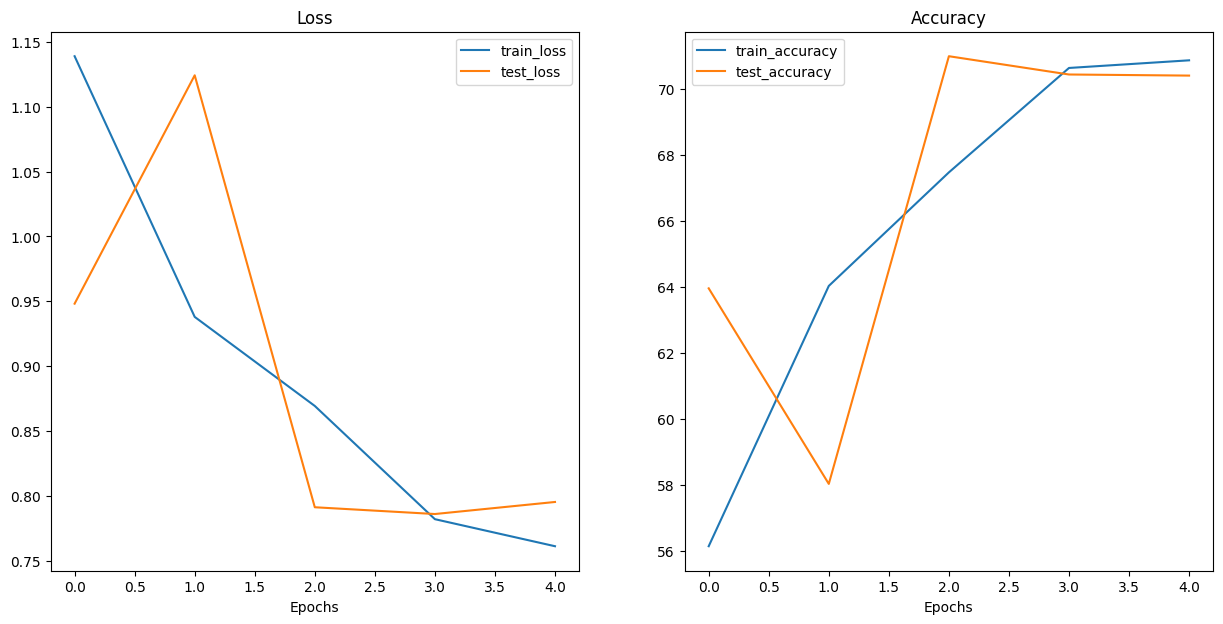

In [55]:
plot_loss_curves(model_0_results)